# Projet FRI
Sylvestre Prabakaran

Benoît Laurès

Benoît Matet

## Class Index
Classe mère pour les index adaptés aux bases de données.
Gère la lemmatization et la tokenization

In [1]:
import string
from typing import List
from scipy.sparse import lil_matrix
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import os
from math import log
import pickle
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.sparse import lil_matrix, csc_matrix, load_npz, save_npz
import re
from tqdm import tqdm
%matplotlib inline

path_to_cacm_file = "/Users/benoit/Desktop/centrale/2018-GTA/FRI/search_engine/data/CACM/cacm.all"
path_to_cs276_dir = "/Users/benoit/Desktop/centrale/2018-GTA/FRI/pa1-data"
path_to_qrels = "/Users/benoit/Desktop/centrale/2018-GTA/FRI/search_engine/qrels.text"
path_to_common_words = "/Users/benoit/Desktop/centrale/2018-GTA/FRI/search_engine/data/common_words"

In [72]:
class Index:
    """
    Base index class.

    Attributes
    ----------
    terms_to_id: dict
        The vocabulary (stemmed words) of the collection where (key, value) = (term (str), id_term (int)).
    id_to_term: dict
        Same dictionary in reverse order (key, value) = (id_term (int), term (str)).
    doc_to_id: dict
        The collection of documents where (key, value) = ('id_doc - title'(str), id_doc (int)).
    id_to_doc: dict
        Same dictionary in reverse order (key, value) = (id_doc (int), 'id_doc - title'(str)).
    incidence_matrix: dict
        Incidence matrix to map terms to their documents.
    """

    def __init__(self):
        self.terms_to_id = {}
        self.id_to_term = {}
        self.doc_to_id = {}
        self.id_to_doc = {}
        self.incidence_matrix = lil_matrix([])

    def build_cacm(self, filename: str):
        raise NotImplementedError

    def build_cs276(self, directory_name: str):
        raise NotImplementedError

    def treat_query(self, query: str) -> List[str]:
        raise NotImplementedError

    def compute_similarity(self, query: str):
        raise NotImplementedError

    def build_vector(self, term: str) -> List[bool]:
        raise NotImplementedError

    @staticmethod
    def normalize(sentence: str) -> List[str]:
        """
        Normalize the given sentence by:
            - Transforming the English contractions to full words
            - Transforming composed words into 2 separated words
            - Tokenizing into words based on white space and punctuation
            - Converting to lower case
            - Removing punctuation
            - Removing non-alphabetical tokens
            - Filtering stop words
            - Stemming words

        Inspired from : https://machinelearningmastery.com/clean-text-machine-learning-python/
        """
        # Take care of English contractions, from: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
        sentence = sentence.replace("'s", ' is')
        sentence = sentence.replace("n't", ' not')
        sentence = sentence.replace("'re", ' are')
        sentence = sentence.replace("'m", ' am')
        sentence = sentence.replace("'ve", ' have')
        sentence = sentence.replace("'ll", ' will')
        sentence = sentence.replace("'d", ' would')
        sentence = sentence.replace("-", ' ')
        
        # Tokenize
        tokens = word_tokenize(sentence)
        # Convert to lower case
        tokens = [w.lower() for w in tokens]
        # Remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # Remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # Filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        # Stemming of words
        porter = PorterStemmer()
        stemmed_words = [porter.stem(word) for word in words]

        return stemmed_words


## Traitement linguistique
Les résultats présentés pour chaque jeu de données sont reproductibles en exécutants les cellules associées.


### CACM
#### Q1
Nous trouvons 118406 tokens dans la collection
#### Q2
Et un vocabulaire de 5462 tokens différents
#### Q3
En ne lisant que la moitié des documents, on trouve un vocabulaire de 3211 tokens différents, avec 32463 tokens au total. On en tire les paramètres de Heap :

    k : 45.14218927762959
    b : 0.41052940261544163
#### Q4
En appliquant les paramètres de Heap, on peut prévoir un vocabulaire de taille 13114 si la collection contenait 1M de tokens.
#### Q5 
Voir les résultats de la cellule

In [3]:

def analysis(filename):
    raw = np.loadtxt(filename, dtype=str, delimiter="someneverhappeningstr")
    keep = False

    term_dic = {}
    doc_id = 0
    nb_docs = 3204  # nb of docs in cacm.all

    V = 0  # nb of distinct words in total data
    T = 0  # nb of tokens in total data

    Vp = 0  # nb of distinct words in half data
    Tp = 0  # nb of tokens in half data

    # Heaps law parameters : V = k * T**b
    k = 0
    b = 0

    for row in raw:
        if row.startswith("."):
            if row.startswith(".I"):
                doc_id += 1  # assumption : docs are read in order
                if doc_id >= nb_docs / 2 and doc_id < nb_docs / 2 + 1:
                    print("At half the docs : ")
                    print("Vocabulary size : {}".format(len(term_dic)))
                    print("Nb tokens : {}".format(sum(term_dic.values())))
                    Vp = len(term_dic)
                    Tp = sum(term_dic.values())
            if row.startswith(".T") or row.startswith(".W") or row.startswith(".K"):
                keep = True
            else:
                keep = False
        elif keep:
            terms = Index.normalize(row)

            for term in terms:
                if term != "":
                    if term not in term_dic:
                        term_dic[term] = 0
                    term_dic[term] += 1

    print("Total")
    print("Vocabulary size : {}".format(len(term_dic)))
    print("Nb tokens : {}".format(sum(term_dic.values())))
    V = len(term_dic)
    T = sum(term_dic.values())

    b = (log(V) - log(Vp)) / (log(T) - log(Tp))
    k = V / (T ** b)
    print("Heaps parameters :")
    print("k : {}".format(k))
    print("b : {}".format(b))
    print("checking the heaps parameters (the 2 following numbers should be equal):")
    print(k * (T ** b))
    print(V)

    print("If the data had 1M tokens, it would have roughly {} distinct words".format(int(k * 1e6 ** b)))

    s = time()
    term_list = sorted(term_dic.items(), key=lambda x: x[1], reverse=True)

    print(term_list[0])
    print(term_list[-1])
    words = [w for w, f in term_list]
    freq = [f for w, f in term_list]
    rank = [i for i in range(len(freq))]
    logrank = [log(i + 1) for i in range(len(freq))]
    logfreq = [log(f + 1) for w, f in term_list]

    plt.figure(1)
    plt.subplot(211)
    plt.plot(rank, freq)
    plt.ylabel("word frequency")
    plt.xlabel("rank")

    plt.subplot(212)
    plt.plot(logrank, logfreq)
    plt.ylabel("log word frequency")
    plt.xlabel("log rank")
    plt.show()



At half the docs : 
Vocabulary size : 3211
Nb tokens : 32463
Total
Vocabulary size : 5462
Nb tokens : 118406
Heaps parameters :
k : 45.14218927762959
b : 0.41052940261544163
checking the heaps parameters (the 2 following numbers should be equal):
5462.0
5462
If the data had 1M tokens, it would have roughly 13114 distinct words
('program', 2111)
('monica', 1)


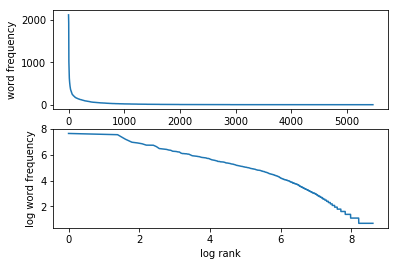

In [4]:
analysis(path_to_cacm_file)

### CS276
Les résultats présentés ici sont reproductibles en exécutants les cellules suivantes.

#### Q1
Nous trouvons 17012440 tokens dans la collection
#### Q2
Et un vocabulaire de 206430 tokens différents
#### Q3
En ne lisant que la moitié des documents, on trouve un vocabulaire de 3211 tokens différents, avec 32463 tokens au total. On en tire les paramètres de Heap :

    k : 26.253357222396655
    b : 1.0934769864217486
    
#### Q4
En appliquant les paramètres de Heap, on peut prévoir un vocabulaire de taille 95509542 si la collection contenait 1M de tokens.
#### Q5 
Voir les résultats de la cellule


In [5]:
def load_saved_dictionnary(file_name):
    """Load the saved dictionnary with pickle"""
    with open(file_name, 'rb') as handle:
        dict = pickle.load(handle)
    return dict


def save_dictionnary(file_name, dict_object):
    """Save the dictionnary"""
    with open(file_name, 'wb') as handle:
        pickle.dump(dict_object, handle, protocol=pickle.HIGHEST_PROTOCOL)


def read_common_words(filePath):
    """Returns the list of the common words listed in the specified file path"""
    file = open(filePath, "r")
    return file.read().splitlines()


def fillDict(directory, tokens):
    """Fill the dictionnay 'tokens' with tokens in the specified directory without any token in the list common_words"""
    listFiles = os.listdir(directory)
    for fileName in listFiles:
        file = open(os.path.join(directory, fileName), "r")
        content = file.readlines()
        for line in content:
            words = Index.normalize(line)
            for word in words:
                tokens[word] = tokens.get(word, 0) + 1


In [6]:

def analysis(dir_path, redo_tokenization=False):
    tokens = dict()
    
    if redo_tokenization:
        print("Reading the dataset")
        for i in range(5):
            directory = os.path.join(dir_path, str(i))
            print("Reading files from directory " + str(i) + " ...")
            fillDict(directory, tokens)
        save_dictionnary("dictionnaireHalf.pkl",tokens)
        for i in range(5,10):
            directory = os.path.join(dir_path, str(i))
            print("Reading files from directory " + str(i) + " ...")
            fillDict(directory, tokens)
        save_dictionnary(os.path.join(dir_path, "dictionnaire.pkl"), tokens)
    else :
        print("Checking the saved results without reading again the dataset")
    
    tokens = load_saved_dictionnary(os.path.join(dir_path, "dictionnaire.pkl"))
    
    #Question1
    print("Question 1 : "+str(sum(tokens.values()))+" terms in the vocabulary")
    
    #Question2
    print("Question 2 : "+str(len(tokens))+" distinct tokens")
    
    #Question3
    M_tot = sum(tokens.values())
    T_tot = len(tokens)
    tokens_half = load_saved_dictionnary("dictionnaireHalf.pkl")
    M_half = sum(tokens_half.values())
    T_half = len(tokens_half)
    b = (log(M_tot) - log(M_half)) / (log(T_tot) - log(T_half))
    k = M_tot/(T_tot**b)
    print("Question 3 : Heaps Law : k = {} and b = {}".format(k,b))
    
    #Question4
    print("Question 4 : For 1 million tokens, the vocabulary size would be {}".format(int(k*1e6**b)))
    
    #Question5
    print("Question 5")
    frequencies = sorted(tokens.values(),reverse=True)
    ranks = [i+1 for i in range(len(frequencies))]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(ranks,frequencies, color='blue', lw=2)
    ax1.set_xlabel("Rang")
    ax1.set_ylabel("Fréquence")
    ax1.set_title("Graphe fréquence vs rang")
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(ranks,frequencies, color='blue', lw=2)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel("Rang")
    ax2.set_ylabel("Fréquence")
    ax2.set_title("Graphe fréquence vs rang (echelle log)")
    plt.show()

Reading the dataset
Reading files from directory 0 ...
Reading files from directory 1 ...
Reading files from directory 2 ...
Reading files from directory 3 ...
Reading files from directory 4 ...
Reading files from directory 5 ...
Reading files from directory 6 ...
Reading files from directory 7 ...
Reading files from directory 8 ...
Reading files from directory 9 ...
Question 1 : 17012440 terms in the vocabulary
Question 2 : 206430 distinct tokens
Question 3 : Heaps Law : k = 26.253357222396655 and b = 1.0934769864217486
Question 4 : For 1 million tokens, the vocabulary size would be 95509542
Question 5


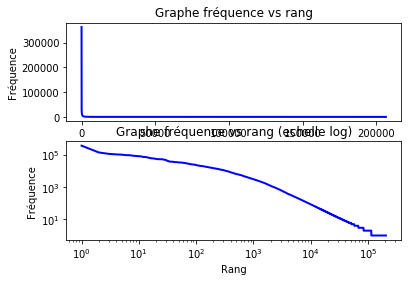

In [7]:
# Set redo_tokenization to True if you want to do again the tokenization and the dictionnary, 
# Otherwise, the saved dictionnary will be loaded

analysis(path_to_cs276_dir, redo_tokenization=True)


## Indexation
La classe BooleanIndex hérite de Index et permet de créer un index inverser sur la base de données CACM ou CS276 selon la méthode appelée. Les requêtes booléennes sont traitées comme un arbre d'opérations en donnant la priorité à NOT, puis OR, puis AND. On peut aussi entrer des requêtes parenthésées.

Pour profiter au mieux de la structure de sparse matrix utilisée pour l'index inversée, l'opérations NOT n'est pas calculée telle quelle. Le résultat renvoyé par le parcours d'arbre renvoie une liste sparse avec un booléen par document, et un booléen indiquant si les documents renvoyés sont les documents pertinents ou au contraire les documents inintéressants. Cela permet de garder une quantité restreinte de documents en mémoire même lorsqu'on demande une requête du type "NOT paper"

### Arbre de requête
Cette cellule contients les fonctions utilitaires pour transformer une requête sous forme de String en un arbre d'opérateurs où chaque nœud est une opération et chaque feuille est un terme de la requête

In [73]:
class Node():
    """
    Node class for a tree representing a boolean query.
    Each node is an operation, each leaf is a token_id
    """
    
    def __init__(self, keyword, left=None, right=None):
        self.keyword = keyword
        
        if keyword in ["not", "and", "or"]:
            
            if right is None:
                raise ArgumentError("no right subtree for this operator")
            self.right = right
            if keyword == "or" or keyword == "and":
                if left is None:
                    raise ArgumentError("no left subtree for an operator of arity 2")
                self.left = left
                
            
    def __repr__(self):
        return str(self.keyword)
        
    def __str__(self):
        return self.__repr__()

    def print_tree(self, depth):
        print("\t"*depth + str(self))
        if hasattr(self, "left"):
            self.left.print_tree(depth+1)
        if hasattr(self, "right"):
            self.right.print_tree(depth+1)
        
def str2list(query):
    """
    :param query: query as a string with keywords, parenthesis and boolean operators
    :returns: query as a list for processing
    """
    query = query.replace("(", " ( ")
    query = query.replace(")", " ) ")
    query = query.lower()
    query = re.sub("\s+", " ", query)
    if query.startswith(" "):
        query = query[1:]
    if query.endswith(" "):
        query = query[:-1]
    query_list = query.split(" ")
    return query_list
    
def remove_par(query_list):
    res = []
    for w in query_list:
        if w != "(" and w != ")":
            res += [w]
    return res

def get_prios(query_list, prio, k):
    """
    Takes a query as a list of words with parenthesis
    Gives a list of priority order in which to handle the words
    """
    prios = []
    while k < len(query_list):
        w = query_list[k]
        if w == "(":
            subtree, k = get_prios(query_list, prio+4, k+1)
            prios += subtree
        elif w == ")":
            return prios, k+1
        elif w == "and" :
            prios += [prio]
            k+=1
        elif w == "or" :
            prios += [prio+1]
            k+=1
        elif w == "not" :
            prios += [prio+2]
            k+=1
        else:
            prios += [prio+3]
            k+=1
    return prios, k+1

def split2tree(words, prios):
    if len(words) == 1:
        return Node(words[0])
    elif len(words) == 0:
        return None
    else:  
        k = np.argmin(prios)
        return Node(words[k], left=split2tree(words[:k], prios[:k]), right=split2tree(words[k+1:], prios[k+1:]))

### Index booléen
Cette classe permet de créer un index pour CACM ou pour CS276 au choix. Elle peut traiter les requêtes booléennes qu'on lui envoie sous forme de string, en créant un arbre tel que définit dans la cellule précédente et en évaluant ensuite cet arbre avec la fonction compute_bool_result

In [81]:

class BooleanIndex(Index):
    def build_cacm(self, filename: str):
        """
        Uses the CACM collection to build the class attributes.
        """
        raw_file = np.loadtxt(filename, dtype=str, delimiter="someneverhappeningstr")
        keep_element = False

        doc_id = -1
        term_id = -1
        title = ''

        nb_terms = 5462 + 2 # for the unknown words (that are in no doc) and stopwords (that are in all docs)
        nb_docs = 3204
        self.incidence_matrix = lil_matrix((nb_terms, nb_docs), dtype=int)  # Boolean index
        self.terms_to_id["__UNK__"] = nb_terms-2
        self.id_to_term[nb_terms-2] = "__UNK__"
        self.terms_to_id["__stopword__"] = nb_terms-1
        self.id_to_term[nb_terms-1] = "__stopword__"
        for i in range(nb_docs):
            self.incidence_matrix[nb_terms-1, i] = 1
        
        for line in raw_file:
            if line.startswith("."):
                keep_element = False
                is_title = False
                if line.startswith(".I"):
                    if title != '':
                        # Map a doc to its ID
                        self.doc_to_id[str(doc_id + 1) + ' -' + title] = doc_id  # Some titles are not unique
                        self.id_to_doc[doc_id] = str(doc_id + 1) + ' -' + title
                    doc_id += 1  # Real doc ID may be different
                    title = ' '
                elif line.startswith(".T") or line.startswith(".W") or line.startswith(".K"):
                    keep_element = True
                    if line.startswith(".T"):
                        is_title = True

            elif keep_element:
                if is_title:
                    title += line + ' '

                terms = self.normalize(line)

                for term in terms:
                    if term != "":
                        if term not in self.terms_to_id.keys():
                            term_id += 1
                            self.terms_to_id[term] = term_id
                            self.id_to_term[term_id] = term
                        self.incidence_matrix[self.terms_to_id[term], doc_id] = 1  # Boolean index

        # Add last doc
        self.doc_to_id[str(doc_id + 1) + ' -' + title] = doc_id
        self.id_to_doc[doc_id] = str(doc_id + 1) + ' -' + title

        self.incidence_matrix = self.incidence_matrix.tocsr()  # Faster row slicing

    def build_cs276(self, directory_name: str):
        """
        Uses the CS276 (Stanford) collection to build boolean_index and saves

        Args :
            directory_name : String containing the path to the CS276 dataset (pa1-data)
        """

        # Creating directory if not existing :
        if not os.path.exists(os.path.join("CS276_boolean_index")):
            os.makedirs(os.path.join("CS276_boolean_index"))

        doc_id = -1
        term_id = -1

        nb_terms = 353975
        nb_docs = 98998

        for block_id in range(10):
            list_of_files = os.listdir(os.path.join(directory_name, str(block_id)))
            block_inc_matrix = lil_matrix((nb_terms, nb_docs))
            print("Building index for block {}:".format(block_id))
            for file_id in tqdm(range(len(list_of_files))):
                # Reading the document
                file = open(os.path.join(directory_name, str(block_id), list_of_files[file_id]), "r")
                content = file.readlines()
                file.close()
                # Adding the document to both doc_to_id and id_to_doc dictionaries
                doc_id += 1
                doc = os.path.join(str(block_id), list_of_files[file_id])
                self.doc_to_id[doc] = doc_id
                self.id_to_doc[doc_id] = doc
                # Counting the terms
                for line in content:
                    terms = self.normalize(line)
                    for term in terms:
                        if term != "":
                            if term not in self.terms_to_id.keys():
                                term_id += 1
                                self.terms_to_id[term] = term_id
                                self.id_to_term[term_id] = term
                            block_inc_matrix[
                                self.terms_to_id[term], doc_id] = 1  # +=1 if we want to count the frequency of the term
            print("Saving block " + str(block_id))
            block_inc_matrix = block_inc_matrix.tocsc()
            save_npz(os.path.join("CS276_boolean_index","block_inc_matrix" + str(block_id) + ".npz"), block_inc_matrix)

        #Saving the four dictionaries
        print("Saving dictionaries")
        with open(os.path.join("CS276_boolean_index",'doc_to_id.pkl'), 'wb') as output_doc_to_id :
            pickle.dump(self.doc_to_id, output_doc_to_id)
        with open(os.path.join("CS276_boolean_index",'id_to_doc.pkl'), 'wb') as output_id_to_doc :
            pickle.dump(self.id_to_doc, output_id_to_doc)
        with open(os.path.join("CS276_boolean_index",'id_to_term.pkl'), 'wb') as output_id_to_term :
            pickle.dump(self.id_to_term, output_id_to_term)
        with open(os.path.join("CS276_boolean_index",'term_to_id.pkl'), 'wb') as output_term_to_id :
            pickle.dump(self.terms_to_id, output_term_to_id)

    def load_cs276_index(self):
        """
        Load the CS276 saved index in .npz format (the build_cs276 function should have been run before
        in order to have the .npz files)
        """
        nb_terms = 353975
        nb_docs = 98998
        print("Loading index matrices")
        self.incidence_matrix = csc_matrix((nb_terms, nb_docs))
        for block_id in range(10):
            self.incidence_matrix += load_npz(os.path.join("CS276_boolean_index","block_inc_matrix" + str(block_id) + ".npz"))
        self.incidence_matrix = self.incidence_matrix.tocsr()

        #Loading the four dictionaries
        print("Loading dictionaries")
        with open(os.path.join("CS276_boolean_index",'doc_to_id.pkl'), 'rb') as input_doc_to_id :
            self.doc_to_id = pickle.load(input_doc_to_id)
        with open(os.path.join("CS276_boolean_index",'id_to_doc.pkl'), 'rb') as input_id_to_doc :
            self.id_to_doc = pickle.load(input_id_to_doc)
        with open(os.path.join("CS276_boolean_index",'id_to_term.pkl'), 'rb') as input_id_to_term :
            self.id_to_term = pickle.load(input_id_to_term)
        with open(os.path.join("CS276_boolean_index",'term_to_id.pkl'), 'rb') as input_term_to_id :
            self.terms_to_id = pickle.load(input_term_to_id)


    def compute_bool_result(self, op):  
        """
        Recursive function to compute the result of a tree given its root
        
        Returns a list of postings and a boolean indicating whether 
        it is a positive list (the result is the list) 
        or a negative list (the result is all docs EXCEPT those in the list)
        """
        if op.keyword == "or":
            left_result, left_pos = self.compute_bool_result(op.left)
            right_result, right_pos = self.compute_bool_result(op.right)
            if left_pos and right_pos:
                return (left_result + right_result).sign(), True
            elif not left_pos and not right_pos:
                return left_result.multiply(right_result), False
            elif left_pos and not right_pos:
                return (right_result-left_result > 0 ).astype(int), False  # you are encouraged to check yourself this formula works
            elif not left_pos and right_pos:
                return (left_result-right_result > 0 ).astype(int), False  # you are encouraged to check yourself this formula works           
             
        elif op.keyword == "and":
            left_result, left_pos = self.compute_bool_result(op.left)
            right_result, right_pos = self.compute_bool_result(op.right)
            if left_pos and right_pos:
                return left_result.multiply(right_result), True
            elif not left_pos and not right_pos:
                return (left_result + right_result).sign(), False
            elif left_pos and not right_pos:
                return (left_result-right_result> 0 ).astype(int), False  # you are encouraged to check yourself this formula works
            elif not left_pos and right_pos:
                return (right_result-left_result > 0 ).astype(int), False # you are encouraged to check yourself this formula works           
                            
        elif op.keyword == "not":
            right_result, right_pos = self.compute_bool_result(op.right)        
            return right_result, not right_pos
        else:
            return self.incidence_matrix[self.terms_to_id[op.keyword]], True


    def treat_query(self, query: str, show_tree: bool=False):
        
        query_list = str2list(query)
        query_words = remove_par(query_list)
        for i in range(len(query_words)):
            if query_words[i] not in ["and", "or", "not"]:
                normalized_word = self.normalize(query_words[i])  # is a list of 1 element
                if len(normalized_word) == 0: # word was a stop word and got filtered
                    print("Warning : word \"{}\" is actually a stopword".format(query_words[i]))
                    query_words[i] = "__stopword__"
                elif normalized_word[0] not in self.terms_to_id:
                    print("Warning : word \"{}\" not in the index".format(query_words[i]))
                    query_words[i] = "__UNK__"
                else:
                    query_words[i] = normalized_word[0]
                    
        prios, _ = get_prios(query_list, 0, 0)
        tree = split2tree(query_words, prios)
        if show_tree:
            print(query_words)
            tree.print_tree(0)
            
        result, pos_list = self.compute_bool_result(tree)
        
        if pos_list:
            _, doc_ids = result.nonzero()
        else:
            ones = np.ones(result.shape, dtype=int)
            _, doc_ids = (ones - result).nonzero()
            
        docs = np.array([doc_id + 1 for doc_id in doc_ids])  # doc ids in the database start at 1

        return docs


### Pertinence des requêtes
Les fonctions de cette cellule implémentent toutes les mesures de pertinence des résultats et permettent de faire des rapport facilement pour l'évaluation des résultats de l'index sur les requêtes qu'on lui soumet

In [82]:

def compute_precision(pred: np.ndarray, true) -> float:
    """
    Computes the precision score from the given predicted and true documents.

    Attributes
    ----------
    pred: ndarray
        The predicted documents.
    true: list, ndarray or set
        The true documents for the searched query.

    Returns
    ----------
    out: float
        Precision score.
    """
    if type(true) != set:
        true = set(true)
    true_positives = set(pred).intersection(true)
    if len(pred) > 0:
        return len(true_positives) / len(pred)
    return None


def compute_recall(pred: np.ndarray, true) -> float:
    """
    Computes the recall score from the given predicted and true documents.
    """
    if type(true) != set:
        true = set(true)
    true_positives = set(pred).intersection(true)
    if len(true) > 0:
        return len(true_positives) / len(true)
    return None


def compute_e_measure(pred: np.ndarray, true, beta=None) -> float:
    """
    Computes the E measure from the given predicted and true documents.
    """
    precision_score = compute_precision(pred, true)
    recall_score = compute_recall(pred, true)
    if beta is None:
        try:
            beta = precision_score / recall_score
        except:
            beta=np.inf
    try:
        return 1 - precision_score * recall_score * (1 + beta ** 2) / (recall_score + precision_score * beta ** 2)
    except:
        return 1


def compute_f_measure(pred: np.ndarray, true, beta=1) -> float:
    """
    Computes the F measure from the given predicted and true documents.
    """
    return 1 - compute_e_measure(pred, true, beta)


def compute_r_measure(pred: np.ndarray, true, max_rank=None) -> float:
    """
    Computes the R-measure (precision at rank R) from the given predicted and true documents.

    Attributes
    ----------
    pred: ndarray
        The predicted documents, ranked in order of relevance.
    true: list, ndarray or set
        The true documents for the searched query.
    max_rank: int
        Maximum rank to consider when computing the precision. If None, max_rank is set to the number of relevant
        documents (i.e. len(true)).

    Returns
    ----------
    out: float
        R-measure.
    """
    if max_rank is None:
        max_rank = len(true)
    elif max_rank > len(pred):
        max_rank = len(pred)
    return compute_precision(pred[:max_rank], true)


def compute_interpolated_precisions(pred: np.ndarray, true) -> list:
    """
    Computes the interpolated precisions score from the given predicted and true documents.

    Attributes
    ----------
    pred: ndarray
        The predicted documents, ranked in order of relevance.
    true: list, ndarray or set
        The true documents for the searched query.

    Returns
    ----------
    out: list
        Interpolated precisions.
    """
    precision = []
    recall = []
    true = set(true)  # Faster computation to do it now.
    # Compute precision and recall scores by adding documents one by one in order of return.
    for k in range(1, len(pred) + 1):
        precision.append(compute_precision(pred[:k], true))
        recall.append(compute_recall(pred[:k], true))

    interpolated_precisions = []
    idx_min_recall = 0
    # Computes interpolated precisions
    for r in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        while idx_min_recall < len(recall) and recall[idx_min_recall] < r:
            idx_min_recall += 1

        if idx_min_recall == len(recall):
            interpolated_precisions.append(0)
        else:
            interpolated_precisions.append(np.max(precision[idx_min_recall:]))

    return interpolated_precisions


def compute_average_precision(pred: np.ndarray, true) -> float:
    """
    Computes the average precision score from the given predicted and true documents.

    Attributes
    ----------
    pred: ndarray
        The predicted documents, ranked in order of relevance.
    true: list, ndarray or set
        The true documents for the searched query.

    Returns
    ----------
    out: float
        Average precision score.
    """
    return np.sum(compute_interpolated_precisions(pred, true)) / 11


def compute_mean_average_precision(queries_pred: list, queries_true: list) -> float:
    """
    Computes the mean average precision score from the given queries.

    Attributes
    ----------
    queries_pred: list[ndarray]
        The predicted documents, ranked in order of relevance, of each query.
    queries_true: list[list], list[ndarray] or list[set]
        The true documents of each query.

    Returns
    ----------
    out: float
        Mean average precision score.
    """
    average_precisions = []
    for idx_query in range(len(queries_pred)):
        average_precisions.append(compute_average_precision(queries_pred[idx_query], queries_true[idx_query]))
    return np.mean(average_precisions)


def plot_precision_recall_curve(pred: np.ndarray, true):
    """
    Plots the recall-precision curve. Must call plt.show() to show.
    """
    recalls = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    interpolated_precisions = compute_interpolated_precisions(pred, true)

    # Rearrange lists for a better plot
    x = []
    y = []
    for k in range(11):
        if k == 0:
            x.append(recalls[k])
            y.append(interpolated_precisions[k])
            y.append(interpolated_precisions[k])
        elif k == 10:
            x.append(recalls[k])
            x.append(recalls[k])
            y.append(interpolated_precisions[k])
        else:
            x.append(recalls[k])
            x.append(recalls[k])
            y.append(interpolated_precisions[k])
            y.append(interpolated_precisions[k])

    plt.figure()
    plt.plot(x, y)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')

    
def read_truth(filepath: str):
    truth = np.loadtxt(filepath, dtype=str, delimiter="\n")
    query_docs = [[] for i in range(66)]
    for row in truth:
        row = re.split("\s+", row)
        id_query = int(row[0])
        id_doc = int(row[1])
        query_docs[id_query] +=[id_doc]
    return query_docs


def full_query_report(query, true_results):
    
    start = time()
    docs = index.treat_query(query, show_tree=True)
    print("Query treated in {:.1f}s".format(time()-start))


    print("Docs found for query : {}".format(query))
    print(docs)
    print("Docs we should have found :")
    print(true_results)
    precision = compute_precision(docs, true_results)
    recall = compute_recall(docs, true_results)
    e_measure = compute_e_measure(docs, true_results)
    f_measure = compute_f_measure(docs, true_results)
    r_measure = compute_r_measure(docs, true_results)
    interpolated_precisions = compute_interpolated_precisions(docs, true_results)
    average_precision = compute_average_precision(docs, true_results)
    
    print("precision :\t\t\t{:.2f}".format(precision))
    print("recall :\t\t\t{:.2f}".format(recall))
    print("e_measure :\t\t\t{:.2f}".format(e_measure))
    print("f_measure :\t\t\t{:.2f}".format(f_measure))
    print("r_measure :\t\t\t{:.2f}".format(r_measure))
    print("interpolated_precisions :\t{}".format(interpolated_precisions))
    print("average_precision :\t\t{:.2f}".format(average_precision))

    
    plot_precision_recall_curve(docs, true_results)
    plt.show()


def short_query_report(query, true_results):
    t = time()
    result = index.treat_query(query, show_tree=False)
    t = time()-t
    precision = compute_precision(result, true_results)
    recall = compute_recall(result, true_results)
    f_measure = compute_f_measure(result, true_results)
    report_str = "query {} :\t".format(id_query)
    if recall is not None:
        report_str += "r : {:.2f}\t".format(recall)
    else : 
        report_str += "r : NaN\t\t"
    if precision is not None:
        report_str += "p : {:.2f}\t".format(precision)
    else : 
        report_str += "p : NaN\t\t"        
    if f_measure is not None:
        report_str += "f1 : {:.2f}\t".format(f_measure)
    else : 
        report_str += "f1 : NaN\t\t"      
    report_str += "({:.2f}s)".format(t)
    print(report_str)
    return result
    

### Evalutation sur CACM

In [83]:
index = BooleanIndex()
start = time()
print("Building index for CACM...")
index.build_cacm(path_to_cacm_file)
print("Index built in {:.1f}s".format(time()-start))



Building index for CACM...
Index built in 19.7s


Query treated in 0.1s
Docs found for query : TSS or (time and sharing and system)
[ 322  585  971  972 1071 1170 1341 1349 1391 1410 1487 1506 1519 1523
 1526 1544 1571 1572 1605 1657 1677 1740 1748 1749 1752 1792 1805 1811
 1827 1844 1877 1892 1901 1908 1938 1951 1960 1978 2036 2054 2069 2092
 2128 2130 2151 2218 2219 2228 2320 2344 2357 2371 2375 2377 2378 2380
 2399 2424 2439 2499 2500 2501 2522 2535 2621 2626 2629 2667 2730 2838
 2867 2920 2938 2947 2948 2950 2951 2954 3025 3112 3174 3204]
Docs we should have found :
[1410 1572 1605 2020 2358]
precision :			0.04
recall :			0.60
e_measure :			0.96
f_measure :			0.07
r_measure :			0.00
interpolated_precisions :	[0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0, 0, 0, 0]
average_precision :		0.10


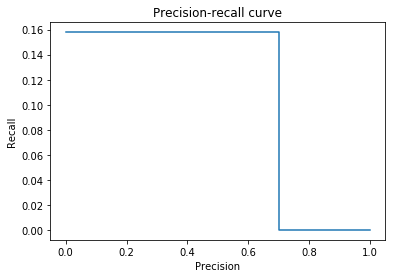

query 1 :	r : 0.60	p : 0.04	f1 : 0.07	(0.01s)
query 2 :	r : 0.00	p : NaN		f1 : 0.00	(0.00s)
query 3 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 4 :	r : 1.00	p : 0.00	f1 : 0.01	(0.01s)
query 5 :	r : 0.25	p : 0.67	f1 : 0.36	(0.01s)
query 6 :	r : 0.33	p : 0.00	f1 : 0.00	(0.01s)
query 7 :	r : 0.00	p : 0.00	f1 : 0.00	(0.01s)
query 8 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 9 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 10 :	r : 0.23	p : 0.53	f1 : 0.32	(0.00s)
query 11 :	r : 0.58	p : 0.31	f1 : 0.40	(0.01s)
query 12 :	r : 0.20	p : 1.00	f1 : 0.33	(0.00s)
query 13 :	r : 0.00	p : NaN		f1 : 0.00	(0.00s)
query 14 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 15 :	r : 0.00	p : NaN		f1 : 0.00	(0.00s)
query 16 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 17 :	r : 0.06	p : 1.00	f1 : 0.12	(0.00s)
query 18 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 19 :	r : 0.73	p : 0.32	f1 : 0.44	(0.00s)
query 20 :	r : 0.33	p : 1.00	f1 : 0.50	(0.00s)


In [84]:
queries = [
    "", # query id starts at 1 in the file
    #  What articles exist which deal with TSS (Time Sharing System), an
    # operating system for IBM computers?
    "TSS or (time and sharing and system)",

    "Prieve or (Udo and Pooch)",
    "intermediate and languages and used and construction and multi-targeted and compilers",
    "(mechanisms and communicating and disjoint and processes) and not abstract",
    "(design or implementation) and ((editing and interfaces) or window-managers or (command and interprets))",
    "(robotics or (motion and planning) or (geometric or combinatorial)) and not (dynamics and arm and motion)",
    "(distributed and algorithm) and (fault-tolerance or correctness)",
    "resource and addressing and network and operating and system",
    "security and local and (networks or (network and operating and system) or (distributed and system)",
    "parallel and language",
    "SETL or (very and high and level and language)",
    "portable and operating and system",
    "code and optimization and space and efficiency",
    "optimal and implementation and sort and algorithms and database and management and applications",
    "horizontal and microcode and optimization and loops",
    "file and handling and operating and systems and multiple and processes and message and passing",
    "optimization and intermediate and machine and code",
    "languages and compilers and parallel and processors and microcoded and machines",
    "parallel and algorithms",
    "graph and theoretic and algorithms and sparse and matrices"
    ]
truth_queries = read_truth(path_to_qrels)

query_report(queries[1], np.array(truth_queries[1]))


result_queries = []

for id_query in range(1, len(queries)):
    result = short_query_report(queries[id_query], truth_queries[id_query])
    result_queries += [result]
    
# mean_average_precision = compute_mean_average_precision(result_queries, truth_queries)
# print("mean average precision on {} queries : {}".format(id_query, mean_average_precision))


    
# mean_average_precision = compute_mean_average_precision(docs, truth_query)
# print("mean_average_precision : {:.2f}".format(mean_average_precision))

### Evalutation sur CS276

In [ ]:

index = BooleanIndex()
start = time()
index.build_cs276(directory_name="/Users/benoit/Desktop/centrale/2018-GTA/FRI/pa1-data")
index.load_cs276_index()
print("Index built in {:.1f}s".format(time()-start))

result = index.treat_query('Assistant OR program')
result = index.treat_query('Assistant OR (program AND NOT tendency AND minimum AND successful)')
print("result : {}".format(result))

  0%|          | 1/10000 [00:00<28:01,  5.95it/s]

Building index for block 0:


100%|██████████| 10000/10000 [04:47<00:00, 34.73it/s]


Saving block 0


  0%|          | 2/10000 [00:00<10:41, 15.57it/s]

Building index for block 1:


100%|██████████| 10000/10000 [04:51<00:00, 36.85it/s]


Saving block 1


  0%|          | 2/10000 [00:00<08:57, 18.62it/s]

Building index for block 2:


100%|██████████| 10000/10000 [06:32<00:00, 20.48it/s]


Saving block 2


  0%|          | 2/10000 [00:00<11:45, 14.18it/s]

Building index for block 3:


100%|██████████| 10000/10000 [04:14<00:00, 39.26it/s]


Saving block 3


  0%|          | 2/9999 [00:00<08:31, 19.53it/s]

Building index for block 4:


100%|██████████| 9999/9999 [03:58<00:00, 41.93it/s]


Saving block 4


  0%|          | 3/9997 [00:00<05:43, 29.07it/s]

Building index for block 5:


100%|██████████| 9997/9997 [1:35:05<00:00,  1.75it/s]     


Saving block 5


  0%|          | 2/9998 [00:00<12:35, 13.23it/s]

Building index for block 6:


 46%|████▋     | 4629/9998 [05:28<31:30,  2.84it/s]  

# 